In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np

Вводные

Водитель может находиться в 4 возможных статусах:
    * free -- доступен для нового заказа
    * enroute -- едет на заказ
    * ontrip -- выполняет заказ
    * busy -- недоступен для нового заказа

Возможные переходы из одного состояние в другое определены как:
    * free -> [free, enroute, busy]
    * enroute -> [free, ontrip]
    * ontrip -> [free]
    * busy -> [free]

Почему переходы определяются таким образом:
1. Из состояния free можно перейти в
    * free -- если водитель ушел в офлайн и заново вышел на линию, тогда подряд будет две записи со статусом free
    * enroute -- если водитель принял заказ, то переходит в статус enroute и едет к клиенту
    * busy -- если водитель нажал кнопку "Занят" в таксометре (пошел на обед и т.д.)
2. Из состояния enroute можно перейти в 
    * free -- если клиент или водитель отменил заказ
    * ontrip -- если водитель приехал к клиенту и начал выполнять заказ
3. Из состояния ontrip можно перейти только в free (после выполнения заказа)
4. Из состояния busy можно перейти только в free

Эффективность на поездке -- это время с клиентом в машине (ontrip), деленное на сумму длительностей всех статусов, связанных с поездкой (sum(free) + enroute + ontrip), где sum(free) -- время простоя.

Время простоя -- это сумма всех статусов free, предшествующих поездке. Суммируются все статусы free, идущие подряд, а также те, которые были прерваны короткими статусами busy или enroute (короткий статус == меньше какого-то TIMEOUT'а).

Имеется набор данных со статусами водителей, по которому необходимо построить зависимость длительности поездки от эффективности.
    * driver_id -- id водителя
    * status -- один из статусов
    * dttm -- время начала статуса

Примечания:
    * Поездка считается только при наличии статуса ontrip
    * Тесты написаны для python 2

    1. Написать функцию-генератор, которая будет отдавать соседние элементы в цикле. Функция понадобится для итерирования по записям водителя и проверки соседних статусов по условиям. Не забудьте проверить, что тесты проходят без ошибок (см. test_neighbors).

In [2]:
def neighbors(iterable):
    # Write generator function which yields 
    # previous, current and next values in iterable list.
    # ... type your code here ...
    iterable=iter(iterable)
    prv = None
    cur = next(iterable)
    try:
        while True:
            nxt = next(iterable)
            yield (prv, cur, nxt)
            prv = cur
            cur = nxt
    except StopIteration:
        yield (prv, cur, None)

In [3]:
# Check if test passes
def test_neighbors():
    test_neighbors = neighbors( range(2) )
    assert next(test_neighbors) == (None, 0, 1)

test_neighbors()

    2. Сгруппировать данные на уровне водителя таким образом, чтобы в одной строке находились все его записи со статусами и началом статуса списком:

Формат исходной таблицы:
<table>
<tr><td>driver_id</td><td>status</td><td>dttm</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>free</td><td>2018-02-04 00:19</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>busy</td><td>2018-02-04 01:03</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>free</td><td>2018-02-03 15:43</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>enroute</td><td>2018-02-03 17:02</td></tr>
<tr><td>...</td><td>...</td><td>...</td></tr>
</table>

Формат сгруппированной таблицы:
<table>
<tr><td>driver_id</td><td>driver_info</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>[("free", 2018-02-04 00:19), ("busy", 2018-02-04 01:03)]</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>[("free", 2018-02-03 15:43), ("enroute", 2018-02-03 17:02) ...]</td></tr>
</table>

In [4]:
df = pd.read_csv("dataset.csv", parse_dates=["dttm"])

# Работать будем с Values
status = df['status'].values
dttm = df['dttm'].values

# Создадим словарь, куда будем накапливать значения:
driver_id_dict = {}
for key, value in enumerate(df['driver_id']):
    if value in driver_id_dict:
        driver_id_dict[value] += [list(zip(status, dttm))[key]]
    else:
        driver_id_dict[value] = [list(zip(status, dttm))[key]]

In [5]:
driver_info = pd.Series(driver_id_dict)
driver_info.head()

8f174ffd446c456eaf3cca0915d0368d    [(free, 2018-02-18T20:51:22.620339000), (enrou...
dc66190e523943f5a83bdd393587439c    [(free, 2018-02-18T20:02:47.620339000), (enrou...
17833e71aa58494ea0cb0a53be840c4e    [(free, 2018-02-18T20:19:26.620339000), (enrou...
63f6aaaf48844d1e83e9fc78716c601e    [(free, 2018-02-18T20:52:11.620339000), (enrou...
78938964fed443cf85879cbf71c6ea56    [(free, 2018-02-18T20:08:57.620339000), (busy,...
dtype: object

    3. Используя функцию neighbors, написать функцию, которая для каждой записи в списке driver_info посчитает ее длительность.

In [6]:
def calc_status_duration(data):
    driver_info_updated = []
    for counter, (status, time) in enumerate(data):
        try:
            time_delta = pd.to_datetime(data[counter+1][1]) - pd.to_datetime(data[counter][1])
            time_delta = time_delta.total_seconds()
            driver_info_updated.append(tuple((status, time, time_delta)))
        except:
            time_delta = None
            driver_info_updated.append(tuple((status, time, time_delta)))
            return driver_info_updated

In [7]:
# Check if test passes
def test_calc_status_duration():
    sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19)), 
                          ("busy", datetime(2018, 4, 2, 1, 3)),]
    sample_driver_info_updated = [('free', datetime(2018, 4, 2, 0, 19), 2640.0),
                                  ('busy', datetime(2018, 4, 2, 1, 3), None),]
    assert calc_status_duration(sample_driver_info) == sample_driver_info_updated

test_calc_status_duration()

In [8]:
for driver_id in driver_info.index:
    driver_info[driver_id] = calc_status_duration(driver_info[driver_id])

In [9]:
# Переведем данные в DataFrame:
df = driver_info.to_frame()
df.columns = ['driver_info']
df.head()


,driver_info
8f174ffd446c456eaf3cca0915d0368d,"[(free, 2018-02-18T20:51:22.620339000, 1470.0)..."
dc66190e523943f5a83bdd393587439c,"[(free, 2018-02-18T20:02:47.620339000, 5126.0)..."
17833e71aa58494ea0cb0a53be840c4e,"[(free, 2018-02-18T20:19:26.620339000, 4884.0)..."
63f6aaaf48844d1e83e9fc78716c601e,"[(free, 2018-02-18T20:52:11.620339000, 700.0),..."
78938964fed443cf85879cbf71c6ea56,"[(free, 2018-02-18T20:08:57.620339000, 674.0),..."


    4. Используя функцию neighbors, написать функцию, которая сформирует из списка driver_info список поездок с информацией о длительности поездки и эффективности (duration_ontrip, efficiency).

In [12]:
TIMEOUT = 1600
def collapse_statuses(driver_info):
    trips = list()
    for i, j, k in neighbors(driver_info):
        try:            
            if i[0] == 'free': 
                new_trip = [0,0,0]
                
                if k[0] == 'free':
                    global free
                    free = 0
                    if j[0] == 'busy':
                        if j[2] < TIMEOUT:
                            free += i[2]
                            #print(i[2])
                            continue
                        else:
                            continue
                        
                    if j[0] == 'enroute':
                        if j[2] < TIMEOUT:
                            free += i[2]
                            #print(i[2])
                            continue
                        else:
                            continue          
            
                if k[0] == 'ontrip':
                    new_trip[0] += k[2]
                    new_trip[1] += j[2]
                    new_trip[2] += i[2]
            
                    
                    new_trip[2] += free
                    free = 0
            
                    #Ontrip = new_trip[0]
                    #Enroute = new_trip[1]
                    #Free2 = new_trip[2]
            
                duration_ontrip = new_trip[0]
                efficiency = new_trip[0] / (new_trip[0] + new_trip[1] + new_trip[2])
                
                trips.append((duration_ontrip, efficiency))

        except TypeError:
            continue  
            
    return trips
       

In [13]:
df["driver_info"] = df.driver_info.apply(collapse_statuses)

    5. Нарисовать и проинтерпретировать зависимость между длительностью поездки и эффективностью.
    Подсказка: требуется сделать обратное преобразование из таблицы со строками на уровне водителя в таблицу со строками на уровне поездки.

In [14]:
driver_id = []
duration_ontrip = []
efficiency = []

for i in df.index:
    for (x, y) in df.loc[i][0]:
        driver_id.append(i)
        duration_ontrip.append(x)
        efficiency.append(y)

In [15]:
trips_df = pd.DataFrame({'driver_id': driver_id, 'duration_ontrip': duration_ontrip, 'efficiency': efficiency})
trips_df.head()

,driver_id,duration_ontrip,efficiency
0,8f174ffd446c456eaf3cca0915d0368d,1664.0,0.195099
1,8f174ffd446c456eaf3cca0915d0368d,3408.0,0.305322
2,8f174ffd446c456eaf3cca0915d0368d,5909.0,0.426458
3,8f174ffd446c456eaf3cca0915d0368d,113.0,0.027262
4,8f174ffd446c456eaf3cca0915d0368d,1987.0,0.261275


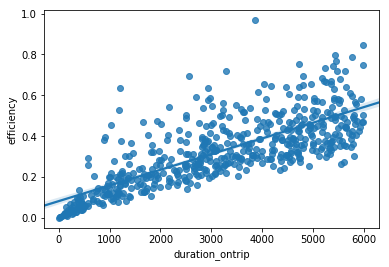

In [16]:
import seaborn as sns
sns.regplot(x = 'duration_ontrip', y = 'efficiency', data = trips_df )

In [17]:
trips_df['duration_ontrip'].corr(trips_df['efficiency'])

0.7644445610503595

**Вывод:** чем больше длительность поездки, тем болье ее эффективность